<a href="https://colab.research.google.com/github/paulstevensonlab/snvm-processing/blob/main/M_Bar_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.fft as fft
from matplotlib.ticker import ScalarFormatter

plt.rcParams.update({
       'font.size': 12,          # Set default font size to 14pt
       'font.family': 'sans-serif',  # Set default font family to ss
       'font.sans-serif': 'Liberation Sans'
   })

In [ ]:
def calc_B(Mx, My, Mz, x, y, z = 50e-9, **kwargs):
  """ calc_B calculates the stray field from an input magnetization using the FFT method outlined in Broadway et al.
  Note: this method can produce FFT artifacts when z is very small (<20nm) unless windows are applied to make M smoothly vary at the edges.

  :param Mx: the x component of the surface magnetization in A
  :param My: the y component of the surface magnetization in A
  :param Mz: the z component of the surface magnetization in A
  :param x: x-axis in m (used for gettting kx correct)
  :param y: y-axis in m (used for gettting ky correct)
  :param z: fly height in m. Defaults to 50nm if not specified.
  """
  kx = 2*np.pi*fft.fftshift( fft.fftfreq(x.shape[0], x[1]-x[0]) )
  ky = 2*np.pi*fft.fftshift( fft.fftfreq(y.shape[0], y[1]-y[0]) )
  kxx, kyy = np.meshgrid(kx, ky)

  kk = np.sqrt(kxx**2 + kyy**2) + 1

  Mx_FT = fft.fftshift(fft.fft2(Mx - np.mean(Mx)))
  My_FT = fft.fftshift(fft.fft2(My - np.mean(My)))
  Mz_FT = fft.fftshift(fft.fft2(Mz - np.mean(Mz)))

  alf = (2*np.pi*1e-7) * np.exp(-kk * z)

  Bx_FT = kxx**2 / kk * Mx_FT + kxx*kyy / kk * My_FT + 1j * kxx * Mz_FT
  By_FT = kxx*kyy / kk * Mx_FT + kyy**2 / kk * My_FT + 1j * kyy * Mz_FT
  Bz_FT = 1j * kxx * Mx_FT + 1j * kyy * My_FT - kk * Mz_FT

  Bx = fft.ifft2( fft.ifftshift(-alf*Bx_FT)).real
  By = fft.ifft2( fft.ifftshift(-alf*By_FT)).real
  Bz = fft.ifft2( fft.ifftshift(-alf*Bz_FT)).real

  return Bx, By, Bz

def gen_M(m_dir, sig = 100e3 * 30e-9, width = 3e-7):
  """ gen_M generates a bar with uniform magnetization specified by m_dir. Optional inputs are sig and width.
  This is hardcoded to produce a horizontal bar in a 2um by 2um region, but can be easily edited if needed

  :param m_dir: a vector (3x1) specifying the magnetization direction.
  :param sig: magnetic surface current; this is M (in A/m) * thickness (in m)
  :param width: the width of the bar in m.
  """
  x = np.linspace(-2e-6, 2e-6, 1000)
  y = np.linspace(-2e-6, 2e-6, 1000)
  xx, yy = np.meshgrid(x, y)
  mask = np.zeros((x.size,y.size))
  mask[np.abs(yy)<width] = sig
  m_dir = m_dir/np.sum(m_dir**2)
  return [m_dir[0]*mask, m_dir[1]*mask, m_dir[2]*mask, x, y]

def calc_and_plot(m_dir, **kwargs):
  """ calc_and_plot generates a bar with uniform magnetization specified by m_dir, calculates the magnetic field and plots it.
  This function is a lazy helper function for gen_M and calc_B, which do the actual calculations.

  :param m_dir: a vector (3x1) specifying the magnetization direction.
  """
  m_oop = gen_M(m_dir, **kwargs)

  B = calc_B(m_oop[0], m_oop[1], m_oop[2], m_oop[3], m_oop[4], **kwargs)
  Bm = np.max(B)
  Mm = np.max(np.abs(m_oop[0:3]))
  if Bm < 1e-7:
    Bm = 1e-7


  fig, ax = plt.subplots(2,3, figsize = (6,4), sharey = True, sharex=True, constrained_layout = True)
  im1 = ax[0,0].pcolormesh(m_oop[0], vmax = Mm, vmin = -Mm, cmap = 'bwr')
  ax[0,1].pcolormesh(m_oop[1], vmax = Mm, vmin = -Mm, cmap = 'bwr')
  ax[0,2].pcolormesh(m_oop[2], vmax = Mm, vmin = -Mm, cmap = 'bwr')
  im2 = ax[1,0].pcolormesh(B[0], vmax = Bm, vmin = -Bm, cmap = 'inferno')
  ax[1,1].pcolormesh(B[1], vmax = Bm, vmin = -Bm, cmap = 'inferno')
  ax[1,2].pcolormesh(B[2], vmax = Bm, vmin = -Bm, cmap = 'inferno')

  titles = ['Mx', 'My', 'Mz', 'Bx', 'By', 'Bz']
  [a.set_title(titles[i]) for i, a in enumerate(ax.flatten())]

  [a.set_yticks([]) for a in ax.flatten()]
  [a.set_xticks([]) for a in ax.flatten()]
  [a.set_aspect('equal') for a in ax.flatten()]

  # Add shared colorbar for magnetization plots
  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-3, 3))
  fig.colorbar(im1, ax=[ax[0,0], ax[0,1], ax[0,2]], location='right', label='Magnetization (A)', format=formatter)
  fig.colorbar(im2, ax=[ax[1,0], ax[1,1], ax[1,2]], location='right', label='B Field (T)', format=formatter)

  plt.show()
  return fig, ax, B, m_oop

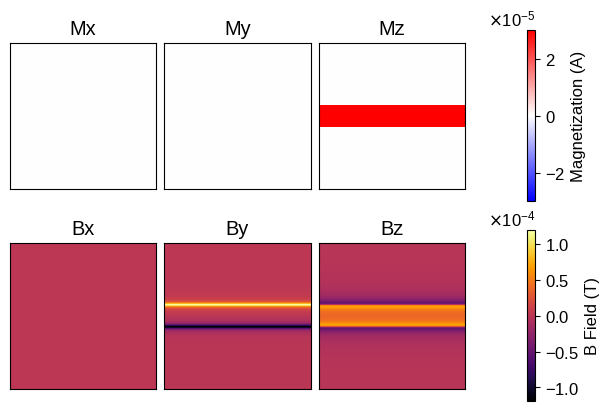

In [ ]:
## OOP magnetization example
m_dir = np.asarray([0,0,1])
fig, ax, B, m_oop = calc_and_plot(m_dir, sig = 1e3 * 30e-9)

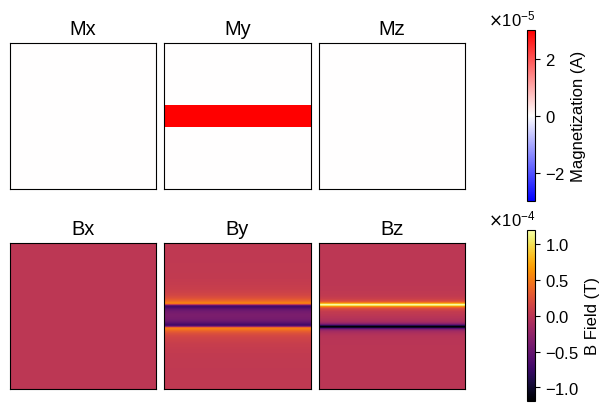

In [ ]:
## IP (y) magnetization example
m_dir = np.asarray([0,1,0])
fig, ax, B, m_oop = calc_and_plot(m_dir, sig = 1e3 * 30e-9)

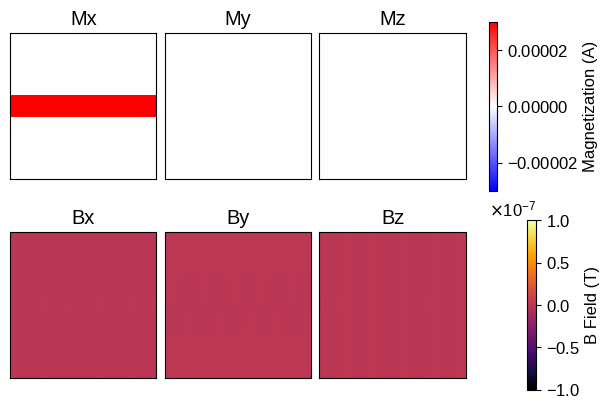

In [ ]:
## IP (x) magnetization example - no field expected here
m_dir = np.asarray([1,0,0])
fig, ax, B, m_oop = calc_and_plot(m_dir, sig = 1e3 * 30e-9)

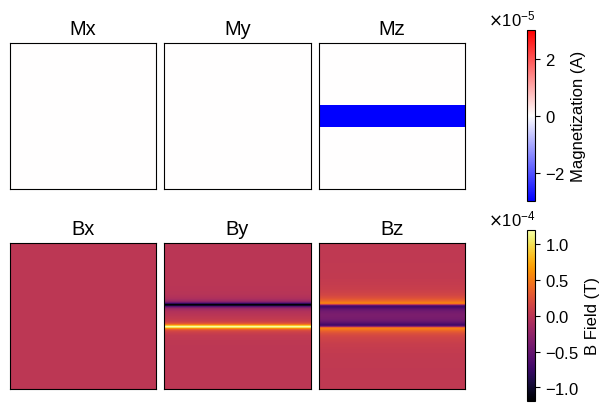

In [ ]:
## Reverse OOP direction
m_dir = np.asarray([0,0,-1])
fig, ax, B, m_oop = calc_and_plot(m_dir, sig = 1e3 * 30e-9)